# JWST Master Class
### NIRCam and MIRI Coronagraphy of HR 8799 bcde

This notebook demonstrates the use of PanCAKE with the NIRCam and MIRI Coronagraphs. Specifically, it provides examples of: 
 * Scene Construction
 * Engine calculations (using the bundled precomputed PSF library)
 * Implementing small-grid dithers (SGDs) with on-the-fly PSFs with WebbPSF. 
</br>

###### *Created for the JWST Master Class 11/19/19. <br> Author: B. Nickson*

------------------------

In [1]:
# Necessary imports
import matplotlib.pyplot as plt
%matplotlib inline

from pandeia.engine.calc_utils import build_default_calc
from pandeia.engine.perform_calculation import perform_calculation

import jwst_pancake as pancake

from copy import deepcopy
import numpy as np

import time

## Scene Construction
We'll start by defining the source and instrument properties for our desired observation.

In [2]:
target_Sp = 'f0v'     
ref_Sp = 'f8v'        

target_mV = 5.24 #vegamag
ref_mV = 5.14 #abmag

Now we'll load in a NIRCam template and configure the instrument for our observation (using the 430R mask and F444W filter as an example).



In [3]:
# Load the template
config = build_default_calc('jwst', 'nircam', 'coronagraphy')

# Set the coronagraph and filter
config['configuration']['detector']['subarray'] = 'sub320'
config['configuration']['detector']['ngroup'] = 8
config['configuration']['detector']['nint'] = 5
config['configuration']['instrument']['aperture'] = 'mask430r'
config['configuration']['instrument']['filter'] = 'f444w'


By default, the template contains a scene with a single star. We'll set the star properties and then duplicate it to create our planetary companions.

In [4]:
# Pull out the target (the first entry in the 'scene' list)
target = config['scene'][0]
target['spectrum']['normalization'] = {'type': 'photsys', 'norm_fluxunit': 'vegamag', 'bandpass': 'johnson,k'}
target['spectrum']['normalization']['norm_flux'] = target_mV
target['spectrum']['sed'] = {'sed_type': 'phoenix'}
target['spectrum']['sed']['key'] = target_Sp
target['id'] = 1

# Copy the target star and turn it into a planet
planetB = deepcopy(target)
planetB['id'] = 2 #each source must have a unique ID, starting at 1

# A different way to normalize source flux
planetB['spectrum']['normalization']['norm_flux'] = 14.05
planetB['spectrum']['sed']['sed_type'] = 'blackbody'
planetB['spectrum']['sed']['temp'] = 870. #Kelvin
del planetB['spectrum']['sed']['key'] #unnecessary now

# Source offset
planetB['position']['x_offset'] = -1.6 #arcsec
planetB['position']['y_offset'] = 0.65

# Copy that planet and turn it into a second one
planetC = deepcopy(planetB)
planetC['id'] = 3
planetC['spectrum']['normalization']['norm_flux'] = 14.05
planetC['spectrum']['sed']['sed_type'] = 'blackbody'
planetC['spectrum']['sed']['temp'] = 1090.
planetC['position']['x_offset'] = 0.75 #arcsec
planetC['position']['y_offset'] = -0.8

# Repeat for third planet
planetD = deepcopy(planetB)
planetD['id'] = 4
planetD['spectrum']['normalization']['norm_flux'] = 13.1
planetD['spectrum']['sed']['sed_type'] = 'blackbody'
planetD['spectrum']['sed']['temp'] = 1090.
planetD['position']['x_offset'] = 1.15 #arcsec
planetD['position']['y_offset'] = 1.3

# Repeat for fourth planet
planetE = deepcopy(planetB)
planetE['id'] = 5
planetE['spectrum']['normalization']['norm_flux'] = 12.93
planetE['spectrum']['sed']['sed_type'] = 'blackbody'
planetE['spectrum']['sed']['temp'] = 1000.
planetE['position']['x_offset'] = 0.4 #arcsec
planetE['position']['y_offset'] = -0.13

# Update calculation file with the new planet
config['scene'].extend([planetB,planetC,planetD,planetE])

Now we'll add in a global offset to the entire scene to capture the effect of target acquisition error.



In [5]:
reference = config['strategy']['psf_subtraction_source']

# We adopt a brighter but spectrally-mismatched reference
reference['id'] = 99
reference['spectrum'] = deepcopy(target['spectrum'])
reference['spectrum']['normalization']['norm_flux'] = ref_mV
reference['spectrum']['sed']['key'] = ref_Sp

# And add target acquisition error
errx_ref, erry_ref = pancake.scene.get_ta_error()
pancake.scene.offset_scene([reference],errx_ref,erry_ref)

And now for the reference scene for PSF subtraction:



In [6]:
reference = config['strategy']['psf_subtraction_source']

# We adopt a brighter but spectrally-mismatched reference
reference['id'] = 99
reference['spectrum'] = deepcopy(target['spectrum'])
reference['spectrum']['normalization']['norm_flux'] = ref_mV
reference['spectrum']['sed']['key'] = ref_Sp

# And add target acquisition error
errx_ref, erry_ref = pancake.scene.get_ta_error()
pancake.scene.offset_scene([reference],errx_ref,erry_ref)

And now we'll plot the two scenes we've constructed



(0, 5.0)

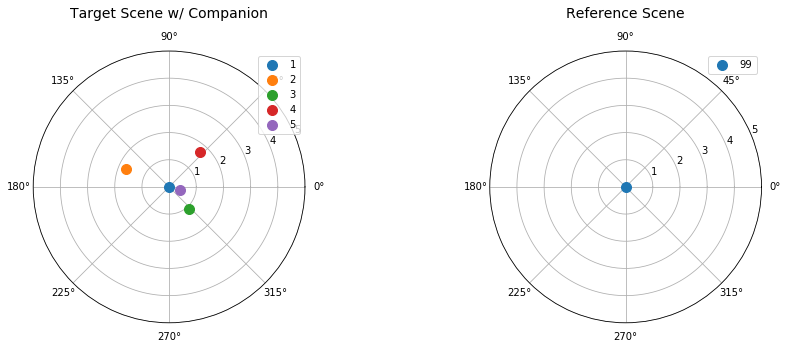

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(121,polar=True)
pancake.scene.plot_scene(config['scene'],'Target Scene w/ Companion',newfig=False)
ax = plt.gca()
ax.set_rlim(0,5.)
plt.subplot(122,polar=True)
pancake.scene.plot_scene([reference],'Reference Scene',newfig=False)
ax = plt.gca()
ax.set_rlim(0,5.)

## Running the Pandeia Engine
Now we pass our calculation files to the pandeia engine to create the slope images (and a number of other products).

/opt/conda/envs/jwst-masterclass/lib/python3.7/site-packages/pysynphot/units.py:913: RuntimeWarning: divide by zero encountered in true_divide
  normalized = flux / resampled._fluxtable


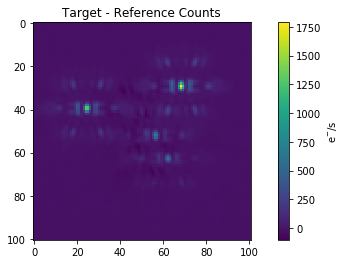

In [8]:
result = pancake.engine.calculate_subtracted(config)
subtracted_slope = result['subtracted']
plt.figure(figsize=(10,4))
plt.imshow(subtracted_slope)
plt.title('Target - Reference Counts')
plt.colorbar().set_label('e$^{-}$/s')

-----------------------------------------
## MIRI Calculation
Now we re-configure our instrument setup for a 4QPM/F1550C calculation.

In [10]:
config['configuration']['instrument']['instrument'] = 'miri'
config['configuration']['instrument']['aperture'] = 'fqpm1550'
config['configuration']['instrument']['filter'] = 'f1550c'
config['configuration']['detector']['subarray'] = 'mask1550'
config['configuration']['detector']['ngroup'] = 500
config['configuration']['detector']['nint'] = 4
config['configuration']['detector']['readout_pattern'] = 'fast'

To simulate a small-grid dither (SGD), we pass in a reference calculation file (after adding TA error) to the `scene.create_SGD` function. By default, this only supports a square 9-point grid with 2 mas error on the grid points, but this function can be easily reproduced for other SGD configurations.

In [11]:
sgds = pancake.scene.create_SGD(ta_error=True, stepsize=20.e-3)

sgd_configs = []
for s in sgds:
    current_config = deepcopy(config)
    pancake.scene.offset_scene([current_config['strategy']['psf_subtraction_source']], *s)
    sgd_configs.append(current_config)

And now lets plot the new MIRI scenes



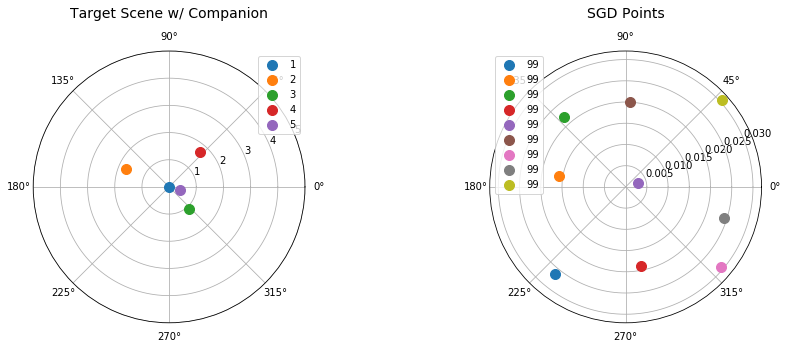

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(121,polar=True)
pancake.scene.plot_scene(config['scene'],'Target Scene w/ Companion',newfig=False)
ax = plt.gca()
ax.set_rlim(0,5.)
plt.subplot(122,polar=True)
for s in sgd_configs:
    pancake.scene.plot_scene([s['strategy']['psf_subtraction_source']],'SGD Points',newfig=False)
ax = plt.gca()

By default, the Pandeia engine relies on a library of sparsely-sampled, pre-computed PSFs which are spatially interpolated to produce the PSF at any given point.  For the MIRI coronagraphs, this sparse sampling will often be insufficient for accurately capturing PSF variations arising from small offsets.

SGDs are an attempt to introduce PSF diversity by sampling variations that arise with small-scale offsets behind the coronagraph masks, so relying on this pre-computed library may not be appropriate. We therefore demonstrate SGDs with this library and by computing PSFs on-the-fly with WebbPSF.

To enable on-the-fly PSFs with WebbPSF, we simply toggle `engine.on_the_fly_PSFs` to `True`.

NB: The number of PSFs generated is given by `engine.wave_sampling` number of sources + `engine.wave_sampling` SGD points. For this example, we're relying on WebbPSF for 280 calculations, which can take a long time. Subsequent calculations can be sped up by use of an LRU cache (enabled by default), but this caching system is incompatible with multiprocessing, so engine.calculate_batch will not contribute to the cache, while engine.perform_calculation will.
</br>
</br>
#### Wave Sampling
*An aside on performance and accuracy*: The `engine.options.wave_sampling` parameter provides a hook into the wavelength sampling of the 3D (x,y,wavelength) cube. By default, Pandeia adopts some large value for the wavelength sampling (typically 150+); however, this is the primary time sink in the calculation. Setting `engine.options.wave_sampling = 10` while developing your simulation provides dramatic time savings while getting within ~5% of the "true" value. By `engine.options.wave_sampling = 40`, one can expect agreement to within roughly 1%.
</br>
</br>


In [13]:
options = pancake.engine.options
initial_options = options.current_options
options.wave_sampling = 11
options.on_the_fly_PSFs = False
otf_options = options.current_options

Now using the calculate_subtracted convenience function:

/opt/conda/envs/jwst-masterclass/lib/python3.7/site-packages/pysynphot/units.py:913: RuntimeWarning: divide by zero encountered in true_divide
  normalized = flux / resampled._fluxtable
/opt/conda/envs/jwst-masterclass/lib/python3.7/site-packages/pysynphot/units.py:913: RuntimeWarning: divide by zero encountered in true_divide
  normalized = flux / resampled._fluxtable
/opt/conda/envs/jwst-masterclass/lib/python3.7/site-packages/pysynphot/units.py:913: RuntimeWarning: divide by zero encountered in true_divide
  normalized = flux / resampled._fluxtable
/opt/conda/envs/jwst-masterclass/lib/python3.7/site-packages/pysynphot/units.py:913: RuntimeWarning: divide by zero encountered in true_divide
  normalized = flux / resampled._fluxtable
/opt/conda/envs/jwst-masterclass/lib/python3.7/site-packages/pysynphot/units.py:913: RuntimeWarning: divide by zero encountered in true_divide
  normalized = flux / resampled._fluxtable
/opt/conda/envs/jwst-masterclass/lib/python3.7/site-packages/pysynphot

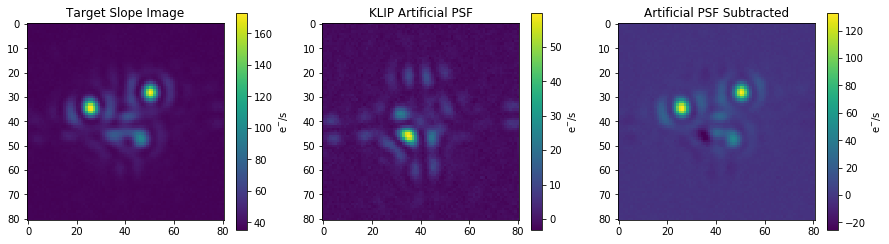

In [14]:
sub_results = pancake.engine.calculate_subtracted(config, ta_error=True, sgd=True, stepsize=20.e-3)

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(sub_results['target'])
plt.title('Target Slope Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(132)
plt.imshow(sub_results['psf'])
plt.title('KLIP Artificial PSF')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(133)
plt.imshow(sub_results['subtracted'])
plt.title('Artificial PSF Subtracted')
plt.colorbar().set_label('e$^{-}$/s')

</br>
</br>

--------------


## Saving Calculation Files
Save out your scene and instrument parameters for quick loading with a future call to engine.load_calculation

In [ ]:
pancake.engine.save_calculation(config, 'mygreatcalculation.json')

## Save Pandeia Images
engine.save_to_fits is provided as a convenience function for quickly saving out arrays or cubes to a FITS file. This doesn't preserve any header values. See http://docs.astropy.org/en/stable/io/fits/ for a more complete treatment of reading and writings FITS files in Python.

In [17]:
# Save out 2d slop images
pancake.engine.save_to_fits(sub_results['target'], 'target_slope.fits')
pancake.engine.save_to_fits(sub_results['psf'], 'reference_slope.fits')
pancake.engine.save_to_fits(sub_results['subtracted'], 'subtracted_slope.fits')